In [1]:
# %pip install -qqq transformers --progress-bar off
# %pip install -qqq pytorch-lightning --progress-bar off
# %pip install -qqq imgkit --progress-bar off
# %pip install -qqq pillow --progress-bar off
# %pip install -qqq easyocr --progress-bar off
# %pip install -qqq --upgrade --no-cache-dir gdown

# install wkhtmltopdf for windows
    https://github.com/wkhtmltopdf/packaging/releases/download/0.12.6-1/wkhtmltox-0.12.6-1.msvc2015-win64.exe

In [2]:
from transformers import LayoutLMv3ForSequenceClassification, LayoutLMv3TokenizerFast, LayoutLMv3FeatureExtractor, LayoutLMv3Processor
from tqdm import tqdm
import torch
from torch. utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from sklearn.model_selection import train_test_split
import imgkit
import easyocr
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2

from typing import List
import json
from torchmetrics import Accuracy



In [3]:
files = list(Path("dataset/documents").glob("*"))

# name conversion to lower case and removal of the blank spaces

for dir in list(Path("dataset/documents").glob("*")):
    dir.rename(str(dir).lower().replace(" ", "_"))


list(Path("dataset/documents").glob("*"))

[WindowsPath('dataset/documents/balance_sheets'),
 WindowsPath('dataset/documents/cash_flow'),
 WindowsPath('dataset/documents/income_statement'),
 WindowsPath('dataset/documents/notes'),
 WindowsPath('dataset/documents/others')]

In [4]:
# Define the path to wkhtmltoimage
config = imgkit.config(wkhtmltoimage=r"C:\Program Files\wkhtmltopdf\bin\wkhtmltoimage.exe")


In [5]:
from pathlib import Path
import imgkit
from PIL import Image

# Define the path to wkhtmltoimage
config = imgkit.config(wkhtmltoimage=r"C:\Program Files\wkhtmltopdf\bin\wkhtmltoimage.exe")

def convert_html_to_image(html_path: Path, images_dir: Path, scale: float = 1.0) -> Path:
    file_name = html_path.with_suffix(".jpg").name
    save_path = images_dir / html_path.parent.name / file_name
    
    # Ensure the directory exists
    save_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Convert HTML to image
    imgkit.from_file(str(html_path), str(save_path), options={'quiet': '', 'format': 'jpeg' }, config=config)
    
    # Open the image to resize
    image = Image.open(save_path)
    width, height = image.size
    image = image.resize((int(width * scale), int(height * scale)))
    image.save(str(save_path))

    return save_path



In [6]:
Path(r"dataset\documents\balance_sheets\18320959_3.html").exists()      #to check if this file also ever existed

True

In [7]:
html_path = Path(r"dataset\documents\balance_sheets\18320959_3.html")
images_dir = Path(r"images")

# Convert HTML to image and resize by 50%
# convert_html_to_image(html_path, images_dir, scale=0.5)

In [8]:
# Example of converting multiple HTML documents to images
document_paths = list(Path(r"./dataset/documents").glob("*/*"))

for doc_path in tqdm(document_paths):
    # convert_html_to_image(doc_path, images_dir, scale=0.8)
    pass

100%|██████████| 2573/2573 [00:00<?, ?it/s]


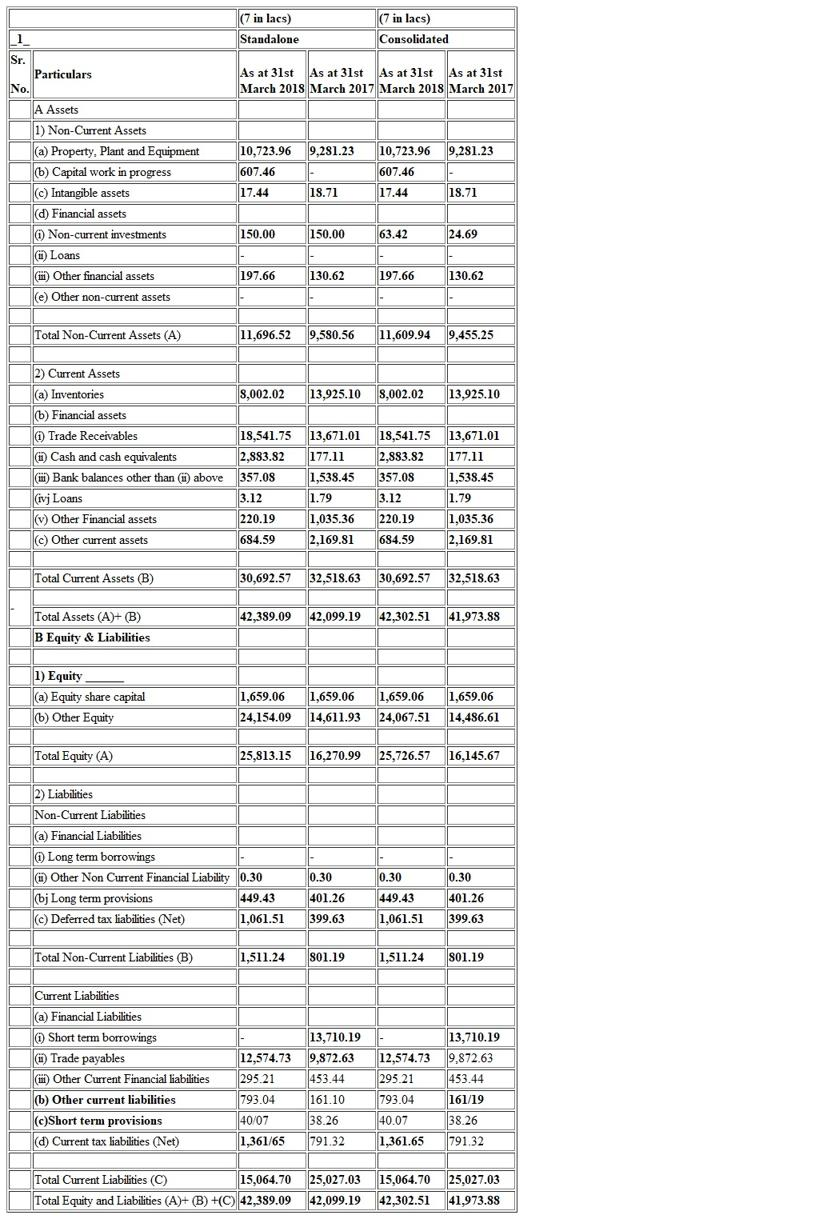

In [9]:
image_paths = list(Path("images").glob("*\*"))
image = Image.open(image_paths[0]).convert("RGB")
image

## Easy OCR

In [10]:
reader = easyocr.Reader(["en"])
reader

In [11]:
%%time
image_path = image_paths[0]
ocr_result = reader.readtext(str(image_path))

CPU times: total: 5.23 s
Wall time: 4.97 s


In [12]:
ocr_result[0]

([[265, 13], [295, 13], [295, 27], [265, 27]], 'lacs)', 0.571474097318266)

In [13]:
def create_bounding_box(bbox_data):
    xs = []
    ys = []

    for x, y in bbox_data:
        xs.append(x)
        ys.append(y)
    
    left = int(min(xs))
    top = int(min(ys))
    right = int(max(xs))
    bottom = int(max(ys))

    return[left, top, right, bottom]


In [14]:
cv2.__path__[0]

'e:\\thesis\\youtube\\venelin\\env\\lib\\site-packages\\cv2'

In [15]:
%ls "{cv2.__path__[0]}"

 Volume in drive E is data
 Volume Serial Number is F8F0-6C7F

 Directory of e:\thesis\youtube\venelin\env\lib\site-packages\cv2

06/11/2024  04:17 PM    <DIR>          .
06/13/2024  11:18 AM    <DIR>          ..
06/11/2024  04:17 PM             6,793 __init__.py
06/11/2024  04:17 PM           304,271 __init__.pyi
06/12/2024  01:25 AM    <DIR>          __pycache__
06/09/2024  05:03 PM    <DIR>          aruco
06/09/2024  05:03 PM    <DIR>          barcode
06/11/2024  04:17 PM               123 config.py
06/11/2024  04:17 PM               748 config-3.py
06/09/2024  05:03 PM    <DIR>          cuda
06/09/2024  05:03 PM        74,214,912 cv2.pyd
06/09/2024  05:03 PM    <DIR>          data
06/09/2024  05:03 PM    <DIR>          detail
06/09/2024  05:03 PM    <DIR>          dnn
06/09/2024  05:03 PM    <DIR>          Error
06/09/2024  05:03 PM    <DIR>          fisheye
06/09/2024  05:03 PM    <DIR>          flann
06/09/2024  05:03 PM    <DIR>          gapi
06/09/2024  05:03 PM    <DIR>       

In [16]:
font_path = "C:/Windows/Fonts/arial.ttf"  
font_size = 14
font = ImageFont.truetype(font_path, font_size)

(-0.5, 818.5, 1218.5, -0.5)

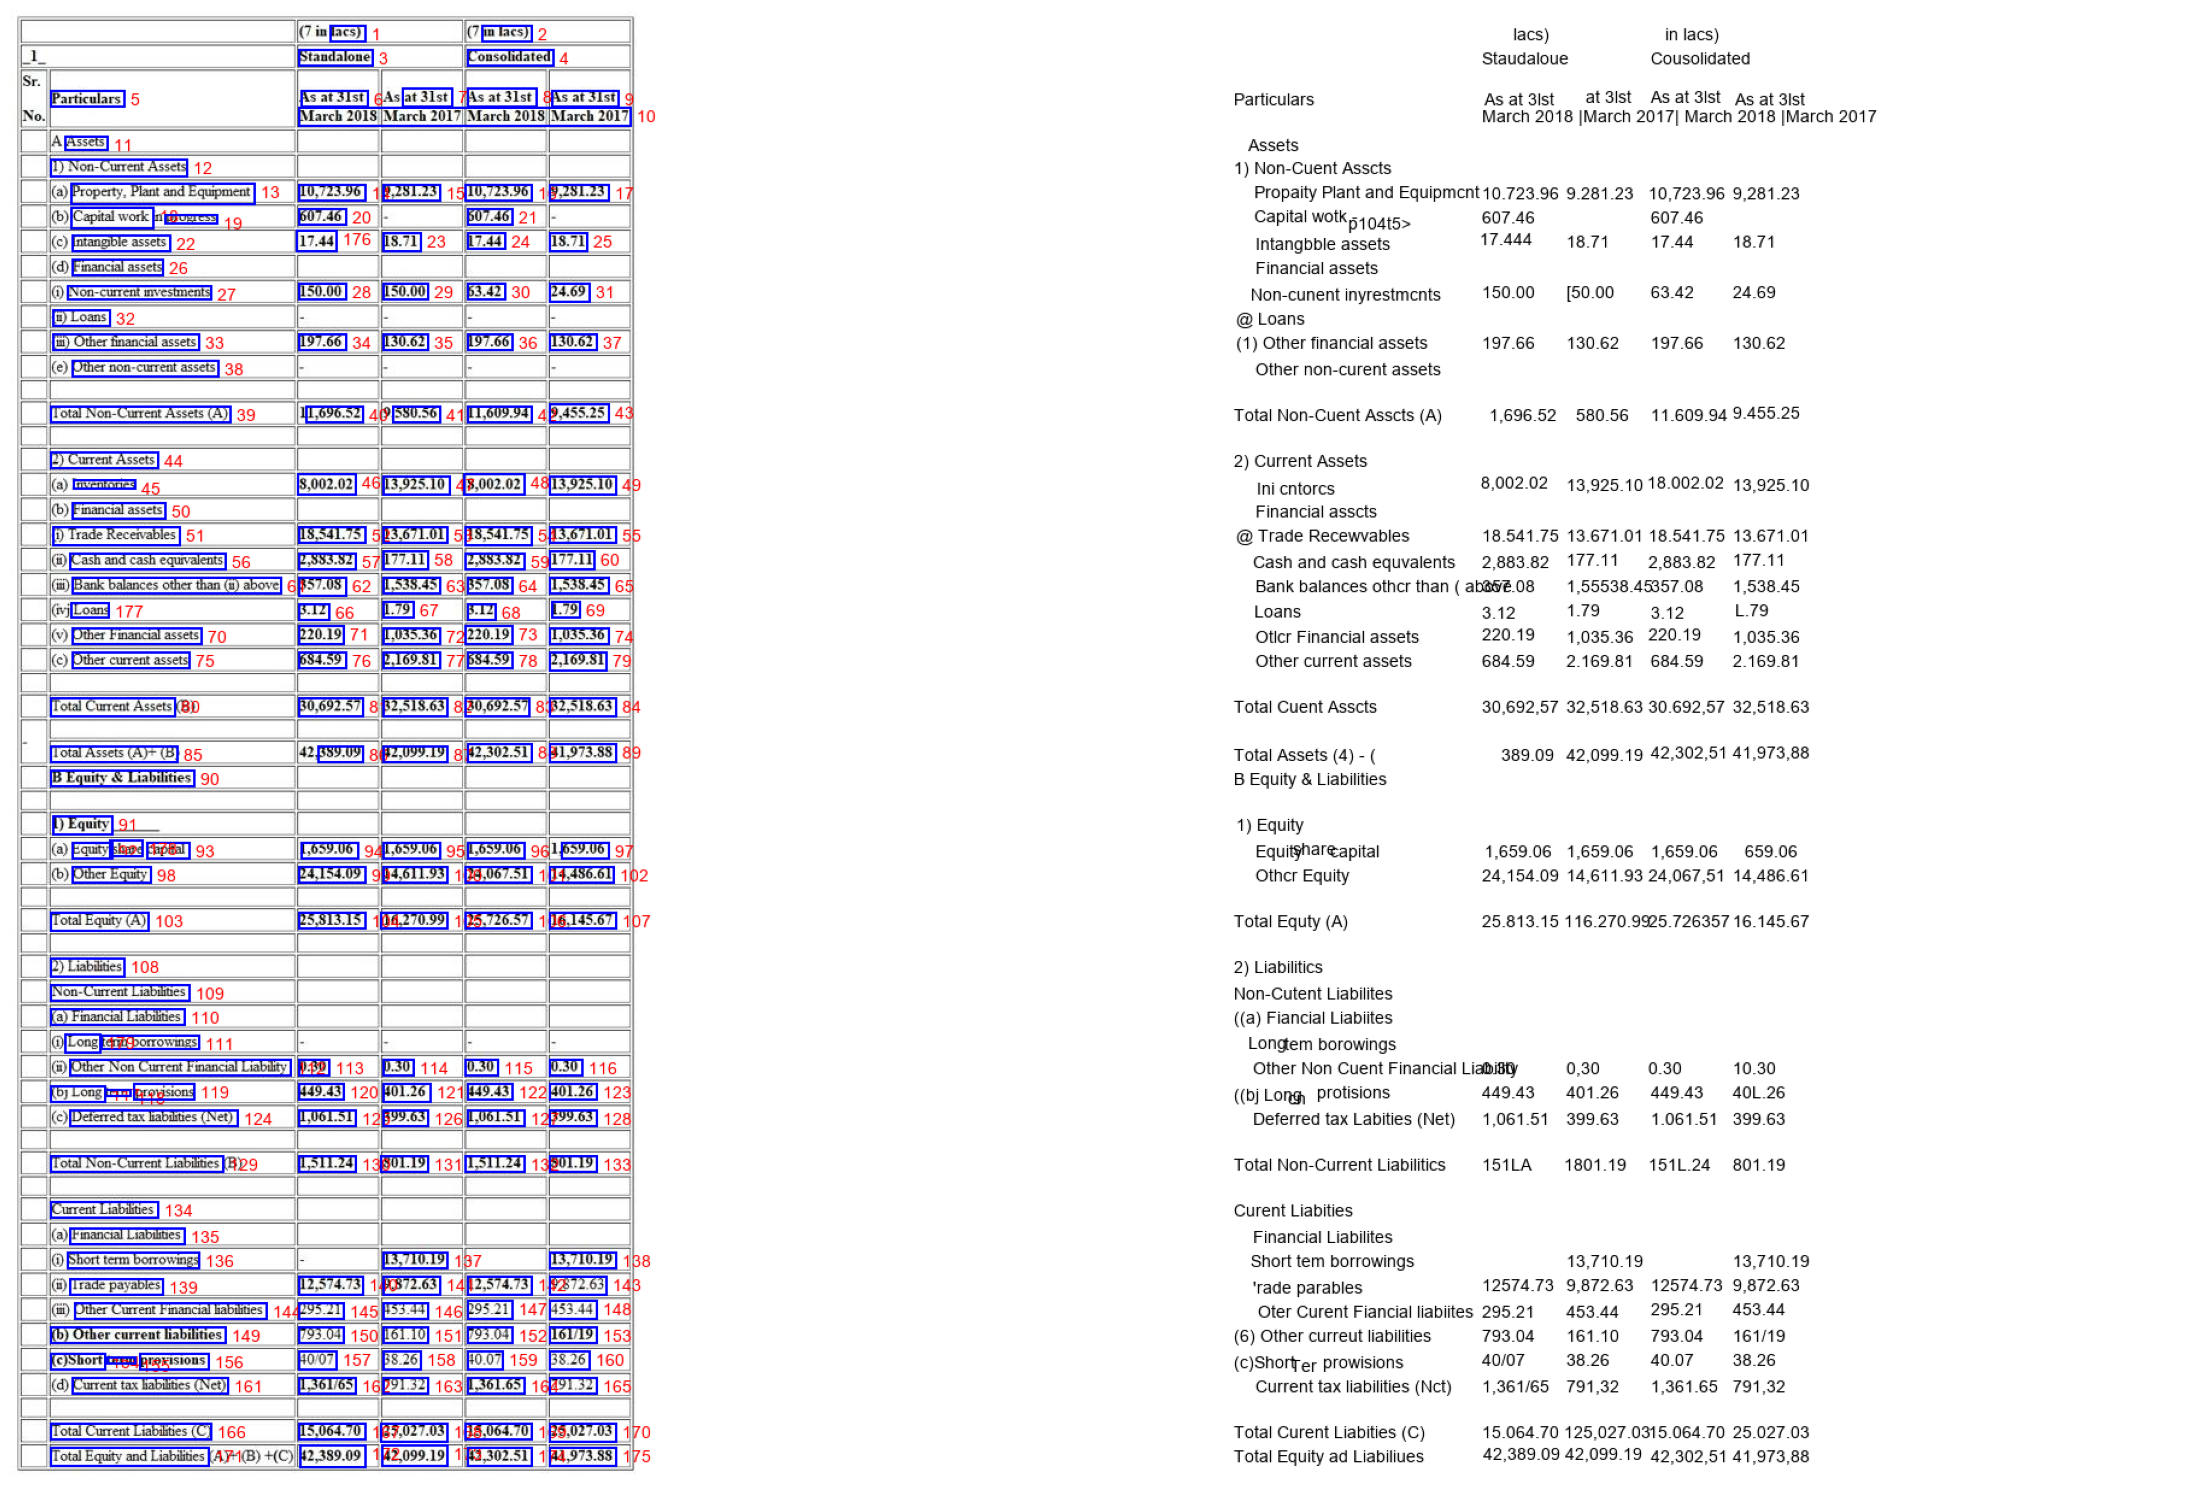

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (28,28))

left_image = Image.open(image_path).convert("RGB")
right_image = Image.new("RGB", left_image.size, (255,255,255))

left_draw = ImageDraw.Draw(left_image)
right_draw = ImageDraw.Draw(right_image)

for i, (bbox, word, confidence) in enumerate(ocr_result):
    box = create_bounding_box(bbox)

    left_draw.rectangle(box, outline="blue", width =2)
    left, top, right, botttom = box

    left_draw.text((right + 5, top), text=str(i+1), fill= "red", font = font)
    right_draw.text((left, top), text=word, fill= "black", font = font)


ax1.imshow(left_image)
ax2.imshow(right_image)
ax1.axis("off")
ax2.axis("off")


## converting to json for faster processing

In [18]:
# Assuming 'image_paths' is a list of directories containing JSON files
image_paths = [Path(p) for p in image_paths]

# Collect all JSON files from the directories
json_files = []
for image_path in image_paths:
    if image_path.is_dir():
        json_files.extend(image_path.glob("*.json"))

for json_file in tqdm(json_files):
    try:
        # Read the JSON file
        with json_file.open("r", encoding='utf-8') as f:
            ocr_page = json.load(f)
        
        # Process the OCR results (if needed)
        for entry in ocr_page:
            word = entry.get("word")
            bounding_box = entry.get("bounding_box")
            # Perform any necessary processing here
        
        # Optionally, you can save the processed data back to the JSON file
        with json_file.open("w", encoding='utf-8') as f:
            json.dump(ocr_page, f, ensure_ascii=False, indent=4)
    except Exception as e:
        print(f"Error processing {json_file}: {e}")


0it [00:00, ?it/s]


In [19]:
# # Ensure `image_paths` contains Path objects
# image_paths = [Path(p) for p in image_paths]

# for image_path in tqdm(image_paths):
#     # Ensure the path is a valid image file before processing
#     if image_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']:
#         try:
#             # Read text from image using EasyOCR
#             ocr_result = reader.readtext(str(image_path), batch_size=16)
            
#             ocr_page = []
#             for bbox, word, confidence in ocr_result:
#                 ocr_page.append({
#                     "word": word, "bounding_box": create_bounding_box(bbox)
#                 })
            
#             # Write OCR results to a JSON file with the same base name as the image
#             json_path = image_path.with_suffix(".json")
#             with json_path.open("w", encoding='utf-8') as f:
#                 json.dump(ocr_page, f, ensure_ascii=False, indent=4)
#         except Exception as e:
#             print(f"Error processing {image_path}: {e}")
#     else:
#         print(f"Skipping non-image file: {image_path}")

In [20]:
image_paths = sorted(list(Path("images").glob("*\*.jpg")))
len(image_paths)

2573

In [21]:
# Initialize feature extractor
feature_extractor = LayoutLMv3FeatureExtractor(apply_ocr=False)

# Initialize tokenizer
tokenizer = LayoutLMv3TokenizerFast.from_pretrained("microsoft/layoutlmv3-base")

# Initialize processor
processor = LayoutLMv3Processor(feature_extractor, tokenizer)

In [22]:
image_path = image_paths[0]
image = Image.open(image_path).convert("RGB")
width, height = image.size
width, height

(819, 1219)

In [23]:
width_scale = 1000 / width
height_scale = 1000 / height

width_scale, height_scale

(1.221001221001221, 0.8203445447087777)

In [24]:
json_path = image_path.with_suffix(".json")     # for that perticular image
json_path

WindowsPath('images/balance_sheets/18320959_3.json')

In [25]:
with json_path.open("r") as f:
    ocr_result = json.load(f)

In [26]:
len(ocr_result)

179

In [27]:
def scale_bounding_box(box: List[int], width_scale: float, height_scale:float) -> List[int]:
    return[
        int(box[0] * width_scale),      #left
        int(box[1] * height_scale),     #top
        int(box[2] * width_scale),      #right
        int(box[3] * height_scale)      #bottom
    ]

In [28]:
words = []
boxes = []

for row in ocr_result:
    boxes.append(scale_bounding_box(row["bounding_box"], width_scale, height_scale))
    words.append(row["word"])

In [29]:
len(ocr_result), len(words), len(boxes) # to check if everything is correct , each word is a different box so length of the word must be equal to the length of the boxes

(179, 179, 179)

In [30]:
encoding = processor(
    image,
    words,
    boxes= boxes,
    max_length=512,
    padding="max_length",
    truncation=True,
    return_tensors='pt'
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask', 'bbox', 'pixel_values'])

In [31]:
print(f"""
input_ids: {list(encoding["input_ids"].squeeze().shape)}
word boxes: {list(encoding["bbox"].squeeze().shape)}
imagedata: {list(encoding["pixel_values"].squeeze().shape)}
image size: {image.size}
      """)


input_ids: [512]
word boxes: [512, 4]
imagedata: [3, 224, 224]
image size: (819, 1219)
      


## DataSet

In [32]:
# how to get the name as the target y set as the name of the folder
image_path, image_path.parent, image_path.parent.name

(WindowsPath('images/balance_sheets/18320959_3.jpg'),
 WindowsPath('images/balance_sheets'),
 'balance_sheets')

In [33]:
list(Path("images").glob("*"))

[WindowsPath('images/balance_sheets'),
 WindowsPath('images/cash_flow'),
 WindowsPath('images/income_statement'),
 WindowsPath('images/notes'),
 WindowsPath('images/others')]

In [34]:
[p.name for p in list(Path("images").glob("*"))]

['balance_sheets', 'cash_flow', 'income_statement', 'notes', 'others']

In [35]:
DOCUMENT_CLASSES = [p.name for p in list(Path("images").glob("*"))]
DOCUMENT_CLASSES

['balance_sheets', 'cash_flow', 'income_statement', 'notes', 'others']

In [36]:
reader = easyocr.Reader(['en'])

class DocumentClassificationDataset(Dataset):
    def __init__(self, image_paths, processor):
        self.image_paths = image_paths
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        ocr_result = reader.readtext(str(image_path))
        
        words = []
        boxes = []
        for res in ocr_result:
            words.append(res[1])
            # Convert bounding box from four points to (x1, y1, x2, y2)
            x_coords = [point[0] for point in res[0]]
            y_coords = [point[1] for point in res[0]]
            boxes.append([min(x_coords), min(y_coords), max(x_coords), max(y_coords)])
        
        # Ensure padding and truncation are set
        try:
            encoded_inputs = self.processor(
                images=image,
                text=words,
                boxes=boxes,
                return_tensors="pt",
                padding="max_length",
                truncation=True
            )
        except Exception as e:
            print(f"Error during processing: {e}")
            raise e
        
        encoded_inputs["labels"] = torch.tensor(DOCUMENT_CLASSES.index(image_path.parent.name))
        
        return encoded_inputs

## train and test subsets

In [37]:
train_images, test_images = train_test_split(image_paths, test_size=.2)
len(train_images), len(test_images)

(2058, 515)

In [38]:
train_dataset = DocumentClassificationDataset(train_images, processor)
test_dataset = DocumentClassificationDataset(test_images, processor)

In [39]:
# Checking a single instance for any obvious issues
for item in train_dataset:
    print(item["input_ids"].shape)
    print(item["bbox"].shape)
    print(item["labels"].shape)
    print(item["labels"].item())
    break

torch.Size([1, 512])
torch.Size([1, 512, 4])
torch.Size([])
2


In [40]:
# Creating data loaders with persistent workers
train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    persistent_workers=True
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    persistent_workers=True
)

In [1]:
class ModelModule(pl.LightningModule):

    def __init__(self, n_classes: int):
        super().__init__()
        self.model = LayoutLMv3ForSequenceClassification.from_pretrained('microsoft/layoutlmv3-base', num_labels=n_classes)
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=n_classes)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.validation_outputs = []

    def forward(self, input_ids, attention_mask=None, bbox=None, images=None):
        # Debugging output
        print(f"Forward pass with inputs: input_ids={input_ids.shape}, attention_mask={attention_mask.shape}, bbox={bbox.shape}, images={images.shape}")
        return self.model(input_ids=input_ids, attention_mask=attention_mask, bbox=bbox, images=images)

    def training_step(self, batch, batch_idx):
        labels = batch["labels"]
        outputs = self(batch["input_ids"], attention_mask=batch["attention_mask"], bbox=batch["bbox"], images=batch["images"])
        loss = self.criterion(outputs.logits, labels)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        labels = batch["labels"]
        outputs = self(batch["input_ids"], attention_mask=batch["attention_mask"], bbox=batch["bbox"], images=batch["images"])
        loss = self.criterion(outputs.logits, labels)
        self.log('val_loss', loss, prog_bar=True)
        acc = self.accuracy(outputs.logits, labels)
        self.log('val_acc', acc, prog_bar=True)
        self.validation_outputs.append({'val_loss': loss, 'val_acc': acc})
        return loss

    def on_validation_epoch_end(self):
        # Custom logic for end of validation epoch if needed
        avg_val_loss = torch.stack([x['val_loss'] for x in self.validation_outputs]).mean()
        avg_val_acc = torch.stack([x['val_acc'] for x in self.validation_outputs]).mean()
        self.log('avg_val_loss', avg_val_loss)
        self.log('avg_val_acc', avg_val_acc)
        self.validation_outputs.clear()

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=2e-5)

NameError: name 'pl' is not defined

In [42]:
model_module = ModelModule(len(DOCUMENT_CLASSES))

Some weights of LayoutLMv3ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs

In [44]:
# import torch

# print("PyTorch version:", torch.__version__)
# print("CUDA available:", torch.cuda.is_available())
# if torch.cuda.is_available():
#     print("CUDA version:", torch.version.cuda)
#     print("CUDA device name:", torch.cuda.get_device_name(0))
# else:
#     print("No CUDA device found")


In [2]:
# Checkpointing
checkpoint_callback = ModelCheckpoint(
    filename='{epoch}-{val_loss:.2f}',
    save_top_k=3,
    monitor='val_loss',
    mode='min'
)

# Trainer
trainer = pl.Trainer(
    max_epochs=10,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1 if torch.cuda.is_available() else None,
    callbacks=[checkpoint_callback]
)

NameError: name 'ModelCheckpoint' is not defined

In [46]:
trainer.fit(model_module, train_data_loader, test_data_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                                | Params
------------------------------------------------------------------
0 | model     | LayoutLMv3ForSequenceClassification | 125 M 
1 | accuracy  | MulticlassAccuracy                  | 0     
2 | criterion | CrossEntropyLoss                    | 0     
------------------------------------------------------------------
125 M     Trainable params
0         Non-trainable params
125 M     Total params
503.686   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]